In [1]:
import jax
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from sklearn import model_selection
import pandas as pd


import nemos as nmo
from nemos import simulation

# enable float64 precision (optional)
jax.config.update("jax_enable_x64", True)

np.random.seed(111)



# Outline
In this introduction to Generalized linear model, we will discuss:
1. What is a GLM
2. Why bother using a GLM
3. Possible use cases
4. How to fit a GLM

# 1. What is a GLM

<a id='glmintro'></a>

## 1.1 Linear Regression
Regression models try to capture the probabalistic relationship between variables of interests $x_i$ (e.g. sensory stimuli, animal's position, choice, etc.) and neural activities $y$. In its simplest form, called **linear regression**:
$$
y = w_1 x_1 + w_2x_2 + ... w_nx_n + b + \epsilon=\mathbf w \cdot \mathbf x + b +\epsilon,
$$
where $\epsilon$ is the residual term, which follows a gaussian distribution. For terminology, $x_i$ are called the ***independent variables*** or ***predictors***, $y$ is called the ***dependent variable*** or ***outcome***, and $w_i$s are called the ***coefficients*** or ***weights***, $b$ is the intercept.

What do the weights mean? If $y$ is the firing rate is a neuron, $x_1$ is a binary variable indicating the turning ON of a stimulus, then $w_1$ means: when all other variables are held constant, turning on the stimulus would **add** $w_1$ to the firing rate. $b$ gives the baseline level of the outcome. 

(A more useful way of writing the above equation in the context of programming is the matrix form: $\mathbf y=\mathbf{X}\mathbf{w}+\mathbf{\epsilon}$, where $\mathbf y$ is an N-vector (N: number of samples, usually time bins), $\mathbf X$ an N-by-D matrix (D: number of predictors, including the bias), $\mathbf w$ a D-vector, and $\mathbf \epsilon \sim Norm(0,\sigma^2I)$. The bias is included in this equation by having one column of the $\mathbf X$ to be 1 and the corresponding element in $\mathbf w$ be $b$.)


## 1.2 GLM

Because the spike counts are positive, discrete, and neurons with higher firing rates also have higher variability, a linear regression is not the most appropriate model. (We will demonstrate why in a later section.)

**Generalized linear model** is an extension of linear regression that generalize to a wider class of response types. In neuroscience, it occurs mostly in this form to model the spike counts:
$$
r = f(\mathbf{w} \cdot \mathbf{x} + b)\\
y \sim Poisson(r),
$$
the **linear** combination of the predictors are passed through a **nonlinear** function $f$, giving rise to the prediction of the firing rate. The non-linear function makes sure the rate is positive. Exponential and softplus are common choices. The dependent variable $y$ is assumed to have a **Poisson distribution** given the firing rate $r$. Therefore these models are also callled **LNP models** (linear-nonlinear-poisson).

What do the weights mean in a GLM? Again, if $y$ is the firing rate of a neuron, $x_1$ is a binary variable indicating the turning ON of a stimulus, then $w_1$ means: when all other variables are held constant, turning on the stimulus would **multiply** the firing rate by $e^{w_1}$. $e^b$ gives the baseline firing rate.

In the rest of this intro, we will demonstrate why these different parts of the GLM are crucial for reaching valid scientific conclusions regarding neural tuning. 


# 2. Why GLM

## 2.1 Linear term: ruling out spurious correlation

A naive approach to measure neural tuning would be to simply plot the average firing rate against the binned predictor variable. For instance, the ratemap of a hippocampal CA1 neuron shows the average firing rate when the animal is at a position bin. Such an approach looks at one variable at a time. However, the result could be misleading when the predictors themselves are correlated. Below we provide an example simulation to demonstrate.

Suppose the rat runs on a linear track, which we bin into five position bins. The running speed across the track follows on average a quadratic relationship where it is higher on the center of the track and lower towards the edges. Yet on a trial to trial basis the speed fluctuates around the mean. This way speed and position are correlated but not fully correlated. 







In [4]:
np.random.seed(110)

In [5]:
n_pos = 5
pos_l = np.arange(n_pos)
speed_per_pos = np.zeros_like(pos_l)
speed_per_pos = -4*(pos_l - n_pos//2) **2 + 16

n_trial = 100
speed_per_pos_per_trial = speed_per_pos + np.random.normal(size=(n_trial,n_pos)) * 2 * speed_per_pos
speed_per_pos_per_trial[speed_per_pos_per_trial<0] = 0

Each dotted curve is the speed per trial. The black solid curve is the average

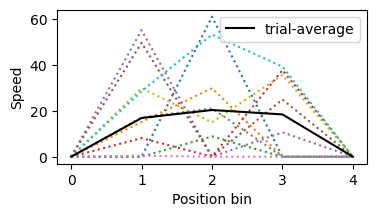

In [6]:
fig,ax=plt.subplots(figsize=(4,2))
ax.plot(speed_per_pos_per_trial[:10].T,linestyle=':')
ax.plot(speed_per_pos_per_trial.mean(axis=0),color='k',label='trial-average')
ax.set_xticks(pos_l)
ax.set(xlabel="Position bin", ylabel='Speed')
ax.legend()

We assume that this neuron does not care about position at all and only care about speed, i.e. $w_{pos}=0$ and $w_{speed} > 0$, see the top left subplot. We then computed dot product between the weight and the predictors (*linear*), exponentiate to get the firing rates (*nonlinear*), and sample spikes from the *Poisson* distribution given the rates. 

Although in the data generation process, the spike trains should have not been affected by position, the tuning curve shows a spurious spatial modulation of the firing rate (top right). Fortunately, using the GLM we were able to find the true weights and the predictor that the neuron actually cares about (bottom left). 

P.S. the models shown here and below all use L1 regularizations, with cross-validation to select the regularizatio penalty. For more on regularization, see (???) 


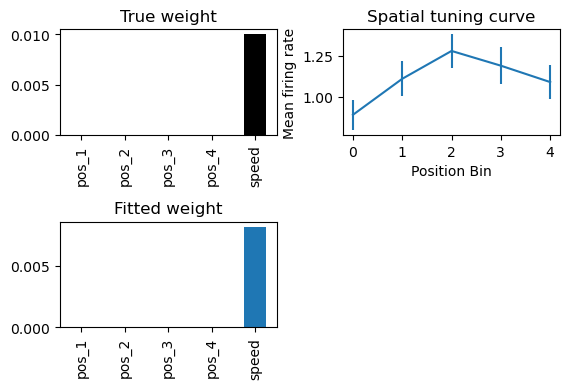

In [16]:
np.random.seed(111)
pos_onehot_t = np.tile(np.eye(n_pos),(n_trial,1))
pos_t = np.tile(pos_l,n_trial)
speed_t = speed_per_pos_per_trial.reshape(-1,1)

X = np.concatenate([pos_onehot_t,speed_t],axis=1)
X = X[:,None,:]
w_true = np.concatenate([[0] * n_pos,[0.01]])[None,:]
rate = jax.numpy.exp(jax.numpy.einsum("ik,tik->ti", w_true, X))
spikes = np.random.poisson(rate)

uid = 0
spk_X_df = pd.DataFrame(X[:,uid,:])
predictor_columns=[f'pos_{i}' for i in range(n_pos)] + ['speed']
spk_X_df.columns = predictor_columns
spk_X_df['spk'] = spikes[:,uid]
spk_X_df['pos'] = pos_t

w_true_series = pd.Series(w_true[0],index=predictor_columns)

fig,axs=plt.subplots(2,2,figsize=(6,4))

# fig,ax=plt.subplots(figsize=(4,2))
ax=axs[0,0]
w_true_series.iloc[1:].plot.bar(ax=ax,color='k') # treatment coding
ax.set_title('True weight')

# fig,ax=plt.subplots(figsize=(4,2))
ax=axs[0,1]
spk_X_df.groupby('pos')['spk'].mean().plot(ax=ax,yerr=spk_X_df.groupby('pos')['spk'].sem())
ax.set(xlabel='Position Bin',ylabel='Mean firing rate',title='Spatial tuning curve')

model = nmo.glm.GLM()
model.set_params(
    regularizer__regularizer_strength=0.06,    
    regularizer=nmo.regularizer.Lasso(),
    observation_model__inverse_link_function=jax.numpy.exp
)

parameter_grid = {"regularizer__regularizer_strength": np.logspace(-4, 1.5, 6)}
cls = model_selection.GridSearchCV(model, parameter_grid, cv=2) # cv=2 to save time; 
cls.fit(X[...,1:], spikes) # treatment coding
w_fit=cls.best_estimator_.coef_


w_fit_series = pd.Series(w_fit[0],index=predictor_columns[1:])
ax=axs[1,0]
w_fit_series.plot.bar(ax=ax)
ax.set_title('Fitted weight')
plt.tight_layout()

axs[1,1].set_visible(False)


A small but important point. You might notice that the weight for position does not include one for pos_0. This is because if it were included, then any position column in the design matrix would be a linear combination of the rest of the position columns plus the bias column (i.e., the design matrix is singular and non-invertible). The ability for one column to explain the data could be shifted around and redistributed to the rest of the columns. Therefore there would not be a unique set of optimal wegihts.

## 2.2 nonlinear - Poisson term: dealing with changing variance 
Linear regression is simple with a closed form formula for the optimal weights. One might wonder why bother with the more complicated procedure of a Poisson GLM. What would happen if one "cheats" a little by using the linear regression to predict the spike counts / firing rates? For one thing, since the output of the linear regression is not constrained, the predictions might contain negative values, which does not make sense. More importantly, it turns out the fitted weights can be very far from the ground truth. Let's first see an example comparison:



In [9]:
import statsmodels 
import statsmodels.formula.api as smf
np.set_printoptions(precision=3,suppress=True)

def gen_data(w_speed=0.01):
    n_pos = 5
    pos_l = np.arange(n_pos)
    speed_per_pos = np.zeros_like(pos_l)
    speed_per_pos = -4*(pos_l - n_pos//2) **2 + 16

    n_trial = 100#500
    speed_per_pos_std = 2 * speed_per_pos
    speed_per_pos_per_trial = speed_per_pos + np.random.normal(size=(n_trial,n_pos)) * speed_per_pos_std
    speed_per_pos_per_trial[speed_per_pos_per_trial<0] = 0

    pos_onehot_t = np.tile(np.eye(n_pos),(n_trial,1))
    pos_t = np.tile(pos_l,n_trial)
    speed_t = speed_per_pos_per_trial.reshape(-1,1)

    X = np.concatenate([pos_onehot_t,speed_t],axis=1)
    X = X[:,None,:]

    w_true = np.concatenate([[0] * n_pos,[w_speed]])[None,:]
    b_true = 0

    rate = jax.numpy.exp(jax.numpy.einsum("ik,tik->ti", w_true, X)+ b_true) 

    spikes = np.random.poisson(rate)
    
    return X,rate, spikes, w_true

In [18]:
np.random.seed(124)
X,rate, spikes, w_true = gen_data(w_speed=0.08)
# X,rate, spikes, w_true = gen_data(w_speed=0.02)
w_true_series = pd.Series(w_true[0],index=predictor_columns)

In [11]:
rate.mean()

Array(12.236, dtype=float64)

In [42]:
from sklearn.linear_model import LassoCV

# model=LassoCV(cv=5,alphas=np.linspace(0.0001,0.01,6))
model=LassoCV(cv=5,alphas=[0.1,1,10,100])
# model.fit(X[:,0,1:],spikes[:,0])
model.fit(X[:,0,1:],spikes[:,0])
print(model.alpha_)

# print('true weight:', w_true[0,1:])
print('true weight:', w_true[0,:])
print('Linear Lasso CV weight:',model.coef_)

0.1
true weight: [0.   0.   0.   0.   0.   0.08]
Linear Lasso CV weight: [-22.651 -12.378 -17.131   0.721   2.093]


In [22]:
w_fit = model.coef_
w_fit_linear_series = pd.Series(w_fit,index=predictor_columns[1:])


In [25]:
model = nmo.glm.GLM()
model.set_params(
    regularizer__regularizer_strength=0.01,#0.01,    
    regularizer=nmo.regularizer.Lasso(),
    observation_model__inverse_link_function=jax.numpy.exp,
#     observation_model__inverse_link_function=jax.nn.softplus
    regularizer__solver_kwargs={'stepsize':0.00001,'maxiter':4000,'tol':0.000001}
)

parameter_grid = {"regularizer__regularizer_strength": np.logspace(-3, 1.5, 6)}
cls = model_selection.GridSearchCV(model, parameter_grid, cv=2)
cls.fit(X[...,1:], spikes)
# cls.fit(X[...], spikes)
print("lasso results")
print("True weights:      ", w_true)
print("Recovered weights: ", cls.best_estimator_.coef_)

w_fit = cls.best_estimator_.coef_
w_fit_poisson_series = pd.Series(w_fit[0],index=predictor_columns[1:])


lasso results
True weights:       [[0.   0.   0.   0.   0.   0.08]]
Recovered weights:  [[ 0.    -0.     0.     0.     0.079]]


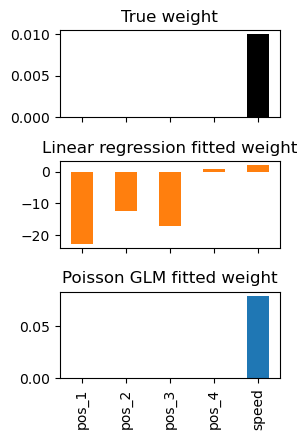

In [41]:
fig,axs = plt.subplots(3,1,figsize=(3,4.5),sharex=True)
ax=axs[0]
w_true_series.iloc[1:].plot.bar(ax=ax,color='k')
ax.set_title('True weight')
ax=axs[1]
w_fit_linear_series.plot.bar(ax=ax,color='C1')
ax.set_title('Linear regression fitted weight')
ax=axs[2]
w_fit_poisson_series.plot.bar(ax=ax)
ax.set_title('Poisson GLM fitted weight')
plt.tight_layout()

For a Poisson random variable, the variance equals the mean, which is its rate. When the neuron has a high rate, for instance, when its favorite stimulus is present, the spike count also varies more across different presentations. However, linear regression assumes the residuals to follow a normal distirbution with the same variance regardless of the values of $y$. When the variances are different, the samples with higher variances should in theory be weighed less according to maximum likelihood estimation. But in practice we still use the formula derived from the equal variance case. Therefore, in effect, we would be weighing the high variances samples "too much."    


# 3. Possible use cases

What types of relationship can we model with GLM? 
- simple case
- non-linear relationship
- temporally extended effect of events

The simple case: if a variable $x$ has a linear relationship with the log-firing rate $z$, i.e. if $x$ is multiplied by 2, $z$ is also multiplied by 2 (e.g. speed in the previous simulation).

However, most variables we encounter do not have such a linear relationship. For instance, place cells are tuned to a particular position, and therefore increasing the position will first increase and then decrease the firing rate. In our previous example, we deal with this issue by binning the position and treat position as a categorical variable. The categorical variable is then turned into one-hot vectors (i.e. 1 for bin $i$ if animal is in one bin $i$ and 0 for the rest).

Text(0.5, 0, 'Variable, discretized')

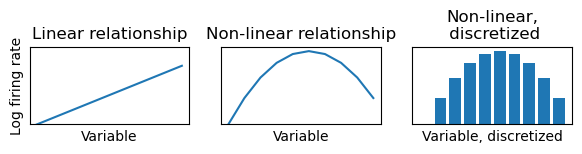

In [339]:
fig,axs=plt.subplots(1,3,sharey=True,figsize=(7,1))
ax=axs[0]
ax.plot([0,1],[0,1])
ax.set_ylabel('Log firing rate')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Linear relationship')
ax.set_xlabel('Variable')

ax=axs[1]
xx = np.arange(10)
ys = (-xx**2 + 10*xx) / 20
ax.plot(ys)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Non-linear relationship')
ax.set_xlabel('Variable')

ax=axs[2]
ax.bar(xx,ys)
ax.set_title('Non-linear,\n discretized')
ax.set_xticks([])
ax.set_xlabel('Variable, discretized')

However, if we divide into too many bins, there will be too many parameters and the estimate will be noisy. Instead, we can use **basis functions** to model this non-linear relationship. Just like basis vectors can be linearly combined to form any vector in a vector space, **basis functions** can be linearly combined to approximate any function in a function space. For instance, non-linear relationship between the log firing rate and a variable (left) can be decomposed into a weighted sum of the basis functions (middle). (Right: each basis function multipled by its weight).


In [332]:
np.random.seed(2)
order = 4
n_basis = 10
mspline_basis = nmo.basis.MSplineBasis(n_basis_funcs=n_basis, order=order)
coord,basis_samples=mspline_basis.evaluate_on_grid(n_samples=100)

w_true = np.random.normal(size=basis_samples.shape[1]) * 0.2
f_true=basis_samples.dot(w_true)


Text(0.5, 1.0, 'Basis functions, weighted')

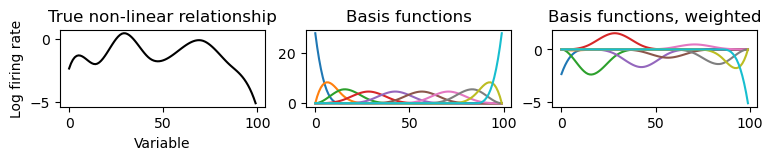

In [338]:
fig,axs=plt.subplots(1,3,figsize=(9,1))
ax=axs[0]
ax.plot(f_true,c='k')
ax.set_ylabel('Log firing rate')
ax.set_xlabel('Variable')
ax.set_title('True non-linear relationship')
ax=axs[1]
ax.plot(basis_samples)
ax.set_title('Basis functions')

ax=axs[2]
basis_samples_weighted = basis_samples * w_true
ax.plot(basis_samples_weighted)
ax.set_title('Basis functions, weighted')

We use an extreme example below to showcase the superiority of using basis functions: single trial tuning-curve inference. We sample spikes from a spatial tuning-curve (top) for a single trial, fit the GLM, and repeat this procedure five times. The GLM fit using a one-hot encoding of the position variable is spatially jagged, often missing the underlying shape of the true tuning vurve, and highly variable from sample to sample (middle). The GLM fit using the basis function (bottom), is able to capture the underlying smooth tuning curve, with much lower varaibility across the random samples.    

In [273]:
def sim_once(axs=None,fig=None,alpha_l1_basis=0.1,alpha_l1_onehot=0.001):
    import scipy
    xs=np.arange(100)
    amp_scale = 10
    true_spatial_tuning_func = lambda xx:scipy.stats.norm(loc=50,scale=5).pdf(xx) * 5 + scipy.stats.norm(loc=65,scale=3).pdf(xx)
    true_spatial_tuning_sample = true_spatial_tuning_func(xs) * amp_scale


    if axs is None:
        fig,axs=plt.subplots(3,1,figsize=(3,4))
    ntrials = 1#20
    rate_concat =np.tile(true_spatial_tuning_sample,(ntrials,))
    pos_concat=np.tile(xs,(ntrials,))
    spikes = np.random.poisson(rate_concat)
    spk_beh_df = pd.DataFrame({'rate':rate_concat,'spikes':spikes,'pos':pos_concat})
    
    ax=axs[0]
    avg=spk_beh_df.groupby('pos').mean()
    avg['rate'].plot(ax=ax,c='k',label='true rate')
    avg['spikes'].plot(ax=ax,c='C1',label='empirical rate')
    ax.legend()
    
    # one-hot fit
    ax=axs[1]
    spikes = spk_beh_df['spikes'].values[:,None]
    X_onehot = pd.get_dummies(spk_beh_df['pos']).astype(float).values
    X_onehot_one = pd.get_dummies(pd.Series(xs)).astype(float).values
    X_onehot = X_onehot[:,None,:]

    model = nmo.glm.GLM()
    model.set_params(
        regularizer__regularizer_strength=alpha_l1_onehot,#0.01,    
        regularizer=nmo.regularizer.Lasso(),
        observation_model__inverse_link_function=jax.numpy.exp,
    #     observation_model__inverse_link_function=jax.nn.softplus
    #     regularizer__solver_kwargs={'stepsize':0.00001,'maxiter':4000,'tol':0.000001}
    )
    model.fit(X_onehot[...,1:], spikes)
    # cls.fit(X[...], spikes)
#     print("lasso results")
#     print("Recovered weights: ", model.coef_)

    w_fit = model.coef_[0]
    w_fit = np.insert(w_fit,0,0)
    # exp_position_tuning = np.exp(X_one.dot(w_fit))
    position_tuning_onehot = np.exp(w_fit) * np.exp(model.intercept_)
    ax.plot(position_tuning_onehot,c='green')
    ax.set_title('Fitted tuning curve\none-hot variables')
    
    # Initialize hyperparameters
    ax=axs[-1]
    
    order = 4
    n_basis = 20#20#20
    # Define the 1D basis function object
    mspline_basis = nmo.basis.MSplineBasis(n_basis_funcs=n_basis, order=order)


    xs_for_basis=spk_beh_df['pos'] / spk_beh_df['pos'].max()
    xs_for_basis_one = xs / np.max(xs)
    X = mspline_basis.evaluate(xs_for_basis)[:,None,:]
    X_one = mspline_basis.evaluate(xs_for_basis_one)
    spikes = spk_beh_df['spikes'].values[:,None]
    
    model = nmo.glm.GLM()
    model.set_params(
        regularizer__regularizer_strength=alpha_l1_basis,#0.01,    
        regularizer=nmo.regularizer.Lasso(),
        observation_model__inverse_link_function=jax.numpy.exp,
    #     observation_model__inverse_link_function=jax.nn.softplus
    #     regularizer__solver_kwargs={'stepsize':0.00001,'maxiter':4000,'tol':0.000001}
    )
    model.fit(X, spikes)
    # cls.fit(X[...], spikes)
#     print("lasso results")
#     print("Recovered weights: ", model.coef_)

    w_fit = model.coef_[0]
    position_tuning_basis = np.exp(X_one.dot(w_fit)) * np.exp(model.intercept_)
    ax.plot(position_tuning_basis)
    ax.set_title('Fitted tuning curve\nbasis function')
    return fig,axs,true_spatial_tuning_sample, position_tuning_onehot, position_tuning_basis


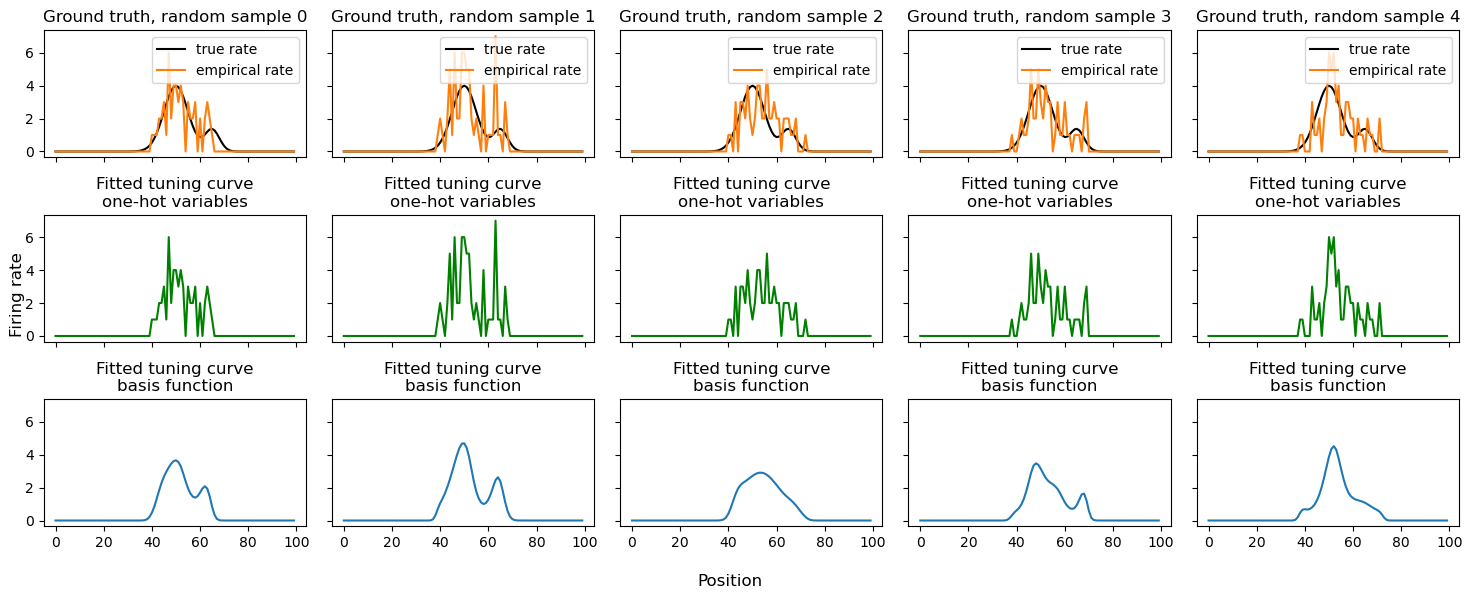

In [298]:
np.random.seed(2)
nsample = 5
fig,axs_all=plt.subplots(3,nsample,figsize=(nsample*3,2*3),sharex=True,sharey=True)

position_tuning_basis_l = []
position_tuning_onehot_l = []

for i in range(nsample):
    fig,axs,true_spatial_tuning_sample, position_tuning_onehot, position_tuning_basis=sim_once(axs=axs_all[:,i],fig=fig,alpha_l1_basis=.00001,alpha_l1_onehot=0.00001)
    position_tuning_onehot_l.append(position_tuning_onehot)
    position_tuning_basis_l.append(position_tuning_basis)
    axs[0].set_title(f'Ground truth, random sample {i}')
fig.supxlabel('Position')
fig.supylabel('Firing rate')
plt.tight_layout()


basis_position_tuning_l = np.array(basis_position_tuning_l)
exp_position_tuning = np.array(exp_position_tuning_l)


Average and standard error of the estimated tuning curve

In [293]:
def plot_mean_and_std(data,fig=None,ax=None,**kwargs):
    if ax is None:
        fig,ax=plt.subplots()
    mean = np.mean(data,axis=0)
    std = np.std(data,axis=0)
#     ax.errorbar(np.arange(len(mean)),mean,yerr=std)
    ax.plot(mean,**kwargs)
    ax.fill_between(np.arange(len(mean)),mean-std,mean+std,alpha=0.5,**kwargs)
    return fig,ax
    
    

Text(0.5, 1.0, 'Fitted tuning curve\nbasis function')

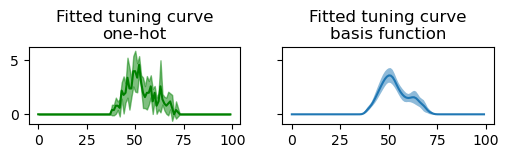

In [341]:
fig,axs=plt.subplots(1,2,figsize=(6,1),sharex=True,sharey=True)
ax=axs[0]
plot_mean_and_std(position_tuning_onehot_l,fig=fig,ax=ax,color='green')
ax.set_title('Fitted tuning curve\none-hot')

ax=axs[1]
plot_mean_and_std(position_tuning_basis_l,fig=fig,ax=ax)
ax.set_title('Fitted tuning curve\nbasis function')



To use the basis function for modeling non-linear relationship with a variable $x$, we transform the original design matrix by ***evaluating*** the basis functions at the values of $x$. The results will be the new predictors, and the weights can be obtained with the usual procedure. The non-linear function is recovered by a weighted sum of the basis. 

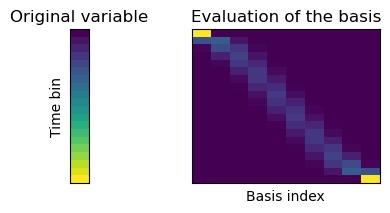

In [374]:
xs_one = np.arange(20) / np.max(xs_one)
fig,axs=plt.subplots(1,2,width_ratios=(0.1,1),figsize=(4,2),sharey=True)
plt.subplots_adjust(wspace=1)
ax=axs[0]
ax.set_title('Original variable')
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(xs_one[:,None],aspect='auto',interpolation='none')
ax.set_ylabel('Time bin')

ax=axs[1]
ax.set_title('Evaluation of the basis')
ax.set_xlabel('Basis index')
ax.set_xticks([])
ax.imshow(mspline_basis.evaluate(xs_one),aspect='auto')

Finally, often the relationship between a predictor and a response is not limited to the current time bin. For instance, visual neurons' responses can be a temporal filter of the stimulus. Spiking histories also affect the probabilities of spiking. The filters are functions of time and can again be decomposed into a weigthed sum of the basis functions. To model temporally extended relationship, we can use ***convolution*** with the basis function to transform our original variables into the new predictors. The estimation of the weights follow the same procedure as before. The filter is recovered by a weighted sum of the basis.

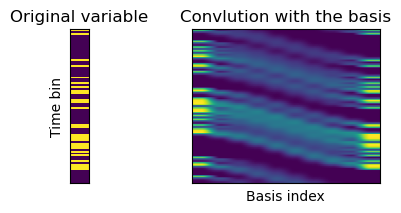

In [392]:
ts_win = np.arange(20) / np.max(xs_one)
ntimes = 100
spk = (np.random.rand(ntimes) < 0.3).astype(float)
fig,axs=plt.subplots(1,2,width_ratios=(0.1,1),figsize=(4,2),sharey=True)
plt.subplots_adjust(wspace=1)
ax=axs[0]
ax.set_title('Original variable')
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(spk[:,None],aspect='auto',interpolation='none')
ax.set_ylabel('Time bin')

ax=axs[1]
ax.set_title('Convlution with the basis')
ax.set_xlabel('Basis index')
ax.set_xticks([])

basis_samples=mspline_basis.evaluate(ts_win)
conv_res=nmo.utils.convolve_1d_trials(basis_samples,[spk[:,None]])

ax.imshow(conv_res[0][:,0,:],aspect='auto')

In summary, the following types of predictors can be used to predict the spikes:

- 1. "Simple": relationship between the predictor and the log firing rate is linear. 
- 2. Non-linear relationship (analog ?): transform the variables using evalution of the basis
- 3. Temporally extended (filtered?): transform the variables using convolution with the basis

# 4. How is GLM fitted

The model specified in [1.2](#glmintro) is a probabalistic model of the spikes. This means we can use the **maximum likelihood estimation (MLE)** to infer the parameters ($\theta = (\mathbf w, b)$). In particular, the likelihood function is a *function of the parameters*, specified by the probability of the outcomes given the predictors and the parameters: $g(\mathbf\theta)=p(\mathbf y|\mathbf X,\mathbf\theta)=\prod_{t=1}^{N}(p(y_t|\mathbf x_t,\mathbf\theta))$. While working with probabilities, the numbers can get really small and cause numerical issues. Therefore it's better to work with the **log likelihood**: $l(\theta) = \mathrm{log}(p(\mathbf y|\mathbf X,\mathbf\theta))=\sum_{t=1}^{N}\mathrm{log} p(y_t|\mathbf x_t,\mathbf\theta)$. Plus, we convert the product into sum, which is simpler to work with.

The MLE is the set of parameters that maximizes the likelihood function:
$\hat{\theta} = \arg \max_{\theta} \sum_{t=1}^{N}\mathrm{log} p(y_t|\mathbf x_t,\mathbf\theta)$

The maximum likelihood estimator of a GLM benefit has some nice properties:

- **Unbiasedness**: The expected value of the ML estimator are the true weights
- **Consistency**: Converges to the true weights in the limit of infinite adata
- **Efficiency**: Achieves minimum possible asymptotic error.

On top of that, for convex and monotonic non-linearities $f$ the log-likelihood of the GLM is convex (
see the figure above for example); this guarantees an extra desirable property:

- **Uniqueness**: the ML weights exists and are unique.

In other words, learning the ML weights is a convex, differentiable optimization problem that can be solved
by standard methods (gradient descent, Newton and quasi-Newton methods).
